Automatic activity recognition systems aim to capture the state of the user and its environment by exploiting heterogeneous sensors, and permit continuous monitoring of numerous physiological signals, where these sensors are attached to the subject's body. This can be immensely useful in healthcare applications, for automatic and intelligent daily activity monitoring for elderly people. 

The Human Activity Recognition database was built from the recordings of 30 study participants performing activities of daily living (ADL) while carrying a waist-mounted smartphone with embedded inertial sensors. The objective is to classify activities into one of the six activities performed.

In [1]:
#Mounting gdrive if working on gdrive
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
#Loading Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import SelectFromModel

from sklearn.metrics import confusion_matrix, classification_report , accuracy_score
from mlxtend.plotting import plot_confusion_matrix
from sklearn.model_selection import cross_val_score


from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB as NB
from sklearn.ensemble import RandomForestClassifier as RF
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.ensemble import GradientBoostingClassifier as GB
from sklearn.tree import DecisionTreeClassifier as DT
from sklearn.ensemble import AdaBoostClassifier as AB
from sklearn.model_selection import GridSearchCV


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
#Response Variable
Activity_label = pd.read_csv('/content/gdrive/My Drive/Datasets/Human Activity data/UCI HAR Dataset Original/activity_labels.txt', header=None, delim_whitespace=True)
Activity_label.columns = ['index', 'activity_label']
Activity_label

,index,activity_label
0,1,WALKING
1,2,WALKING_UPSTAIRS
2,3,WALKING_DOWNSTAIRS
3,4,SITTING
4,5,STANDING
5,6,LAYING


In [4]:
#Feature Set
feature_label = pd.read_csv('/content/gdrive/My Drive/Datasets/Human Activity data/UCI HAR Dataset Original/features.txt', header=None, delim_whitespace=True)
feature_label.columns = ['index', 'feature_label']
feature_label

,index,feature_label
0,1,tBodyAcc-mean()-X
1,2,tBodyAcc-mean()-Y
2,3,tBodyAcc-mean()-Z
3,4,tBodyAcc-std()-X
4,5,tBodyAcc-std()-Y
...,...,...
556,557,"angle(tBodyGyroMean,gravityMean)"
557,558,"angle(tBodyGyroJerkMean,gravityMean)"
558,559,"angle(X,gravityMean)"
559,560,"angle(Y,gravityMean)"


In [0]:
#Loading the Dataset
Train_data = pd.read_csv('/content/gdrive/My Drive/Datasets/Human Activity data/UCI HAR Dataset Original/train/X_train.txt', header=None, delim_whitespace=True)
Train_data.columns = feature_label["feature_label"]
Train_data_subject = pd.read_csv('/content/gdrive/My Drive/Datasets/Human Activity data/UCI HAR Dataset Original/train/subject_train.txt', header=None, delim_whitespace=True)
Train_data_subject.columns = ['subject']
Train_data_label = pd.read_csv('/content/gdrive/My Drive/Datasets/Human Activity data/UCI HAR Dataset Original/train/y_train.txt', header=None, delim_whitespace=True)
Train_data_label.columns = ['activity']

Test_data = pd.read_csv('/content/gdrive/My Drive/Datasets/Human Activity data/UCI HAR Dataset Original/test/X_test.txt', header=None, delim_whitespace=True)
Test_data.columns = feature_label["feature_label"]
Test_data_subject = pd.read_csv('/content/gdrive/My Drive/Datasets/Human Activity data/UCI HAR Dataset Original/test/subject_test.txt', header=None, delim_whitespace=True)
Test_data_subject.columns = ['subject']
Test_data_label = pd.read_csv('/content/gdrive/My Drive/Datasets/Human Activity data/UCI HAR Dataset Original/test/y_test.txt', header=None, delim_whitespace=True)
Test_data_label.columns = ['activity']

In [6]:
#Train dataset
train = pd.concat([Train_data,Train_data_subject,Train_data_label], axis=1)
train.head()

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,tBodyAcc-max()-Y,tBodyAcc-max()-Z,tBodyAcc-min()-X,tBodyAcc-min()-Y,tBodyAcc-min()-Z,tBodyAcc-sma(),tBodyAcc-energy()-X,tBodyAcc-energy()-Y,tBodyAcc-energy()-Z,tBodyAcc-iqr()-X,tBodyAcc-iqr()-Y,tBodyAcc-iqr()-Z,tBodyAcc-entropy()-X,tBodyAcc-entropy()-Y,tBodyAcc-entropy()-Z,"tBodyAcc-arCoeff()-X,1","tBodyAcc-arCoeff()-X,2","tBodyAcc-arCoeff()-X,3","tBodyAcc-arCoeff()-X,4","tBodyAcc-arCoeff()-Y,1","tBodyAcc-arCoeff()-Y,2","tBodyAcc-arCoeff()-Y,3","tBodyAcc-arCoeff()-Y,4","tBodyAcc-arCoeff()-Z,1","tBodyAcc-arCoeff()-Z,2","tBodyAcc-arCoeff()-Z,3","tBodyAcc-arCoeff()-Z,4","tBodyAcc-correlation()-X,Y","tBodyAcc-correlation()-X,Z","tBodyAcc-correlation()-Y,Z",...,fBodyBodyAccJerkMag-entropy(),fBodyBodyAccJerkMag-maxInds,fBodyBodyAccJerkMag-meanFreq(),fBodyBodyAccJerkMag-skewness(),fBodyBodyAccJerkMag-kurtosis(),fBodyBodyGyroMag-mean(),fBodyBodyGyroMag-std(),fBodyBodyGyroMag-mad(),fBodyBodyGyroMag-max(),fBodyBodyGyroMag-min(),fBodyBodyGyroMag-sma(),fBodyBodyGyroMag-energy(),fBodyBodyGyroMag-iqr(),fBodyBodyGyroMag-entropy(),fBodyBodyGyroMag-maxInds,fBodyBodyGyroMag-meanFreq(),fBodyBodyGyroMag-skewness(),fBodyBodyGyroMag-kurtosis(),fBodyBodyGyroJerkMag-mean(),fBodyBodyGyroJerkMag-std(),fBodyBodyGyroJerkMag-mad(),fBodyBodyGyroJerkMag-max(),fBodyBodyGyroJerkMag-min(),fBodyBodyGyroJerkMag-sma(),fBodyBodyGyroJerkMag-energy(),fBodyBodyGyroJerkMag-iqr(),fBodyBodyGyroJerkMag-entropy(),fBodyBodyGyroJerkMag-maxInds,fBodyBodyGyroJerkMag-meanFreq(),fBodyBodyGyroJerkMag-skewness(),fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)",subject,activity
0,0.288585,-0.020294,-0.132905,-0.995279,-0.983111,-0.913526,-0.995112,-0.983185,-0.923527,-0.934724,-0.567378,-0.744413,0.852947,0.685845,0.814263,-0.965523,-0.999945,-0.999863,-0.994612,-0.994231,-0.987614,-0.943220,-0.407747,-0.679338,-0.602122,0.929294,-0.853011,0.359910,-0.058526,0.256892,-0.224848,0.264106,-0.095246,0.278851,-0.465085,0.491936,-0.190884,0.376314,0.435129,0.660790,...,-1.0,-0.936508,0.346989,-0.516080,-0.802760,-0.980135,-0.961309,-0.973653,-0.952264,-0.989498,-0.980135,-0.999240,-0.992656,-0.701291,-1.000000,-0.128989,0.586156,0.374605,-0.991990,-0.990697,-0.989941,-0.992448,-0.991048,-0.991990,-0.999937,-0.990458,-0.871306,-1.000000,-0.074323,-0.298676,-0.710304,-0.112754,0.030400,-0.464761,-0.018446,-0.841247,0.179941,-0.058627,1,5
1,0.278419,-0.016411,-0.123520,-0.998245,-0.975300,-0.960322,-0.998807,-0.974914,-0.957686,-0.943068,-0.557851,-0.818409,0.849308,0.685845,0.822637,-0.981930,-0.999991,-0.999788,-0.998405,-0.999150,-0.977866,-0.948225,-0.714892,-0.500930,-0.570979,0.611627,-0.329549,0.284213,0.284595,0.115705,-0.090963,0.294310,-0.281211,0.085988,-0.022153,-0.016657,-0.220643,-0.013429,-0.072692,0.579382,...,-1.0,-0.841270,0.532061,-0.624871,-0.900160,-0.988296,-0.983322,-0.982659,-0.986321,-0.991829,-0.988296,-0.999811,-0.993979,-0.720683,-0.948718,-0.271958,-0.336310,-0.720015,-0.995854,-0.996399,-0.995442,-0.996866,-0.994440,-0.995854,-0.999981,-0.994544,-1.000000,-1.000000,0.158075,-0.595051,-0.861499,0.053477,-0.007435,-0.732626,0.703511,-0.844788,0.180289,-0.054317,1,5
2,0.279653,-0.019467,-0.113462,-0.995380,-0.967187,-0.978944,-0.996520,-0.963668,-0.977469,-0.938692,-0.557851,-0.818409,0.843609,0.682401,0.839344,-0.983478,-0.999969,-0.999660,-0.999470,-0.997130,-0.964810,-0.974675,-0.592235,-0.485821,-0.570979,0.273025,-0.086309,0.337202,-0.164739,0.017150,-0.074507,0.342256,-0.332564,0.239281,-0.136204,0.173863,-0.299493,-0.124698,-0.181105,0.608900,...,-1.0,-0.904762,0.660795,-0.724697,-0.928539,-0.989255,-0.986028,-0.984274,-0.990979,-0.995703,-0.989255,-0.999854,-0.993238,-0.736521,-0.794872,-0.212

In [7]:
#Test dataset
test = pd.concat([Test_data,Test_data_subject,Test_data_label], axis=1)
test.head()

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,tBodyAcc-max()-Y,tBodyAcc-max()-Z,tBodyAcc-min()-X,tBodyAcc-min()-Y,tBodyAcc-min()-Z,tBodyAcc-sma(),tBodyAcc-energy()-X,tBodyAcc-energy()-Y,tBodyAcc-energy()-Z,tBodyAcc-iqr()-X,tBodyAcc-iqr()-Y,tBodyAcc-iqr()-Z,tBodyAcc-entropy()-X,tBodyAcc-entropy()-Y,tBodyAcc-entropy()-Z,"tBodyAcc-arCoeff()-X,1","tBodyAcc-arCoeff()-X,2","tBodyAcc-arCoeff()-X,3","tBodyAcc-arCoeff()-X,4","tBodyAcc-arCoeff()-Y,1","tBodyAcc-arCoeff()-Y,2","tBodyAcc-arCoeff()-Y,3","tBodyAcc-arCoeff()-Y,4","tBodyAcc-arCoeff()-Z,1","tBodyAcc-arCoeff()-Z,2","tBodyAcc-arCoeff()-Z,3","tBodyAcc-arCoeff()-Z,4","tBodyAcc-correlation()-X,Y","tBodyAcc-correlation()-X,Z","tBodyAcc-correlation()-Y,Z",...,fBodyBodyAccJerkMag-entropy(),fBodyBodyAccJerkMag-maxInds,fBodyBodyAccJerkMag-meanFreq(),fBodyBodyAccJerkMag-skewness(),fBodyBodyAccJerkMag-kurtosis(),fBodyBodyGyroMag-mean(),fBodyBodyGyroMag-std(),fBodyBodyGyroMag-mad(),fBodyBodyGyroMag-max(),fBodyBodyGyroMag-min(),fBodyBodyGyroMag-sma(),fBodyBodyGyroMag-energy(),fBodyBodyGyroMag-iqr(),fBodyBodyGyroMag-entropy(),fBodyBodyGyroMag-maxInds,fBodyBodyGyroMag-meanFreq(),fBodyBodyGyroMag-skewness(),fBodyBodyGyroMag-kurtosis(),fBodyBodyGyroJerkMag-mean(),fBodyBodyGyroJerkMag-std(),fBodyBodyGyroJerkMag-mad(),fBodyBodyGyroJerkMag-max(),fBodyBodyGyroJerkMag-min(),fBodyBodyGyroJerkMag-sma(),fBodyBodyGyroJerkMag-energy(),fBodyBodyGyroJerkMag-iqr(),fBodyBodyGyroJerkMag-entropy(),fBodyBodyGyroJerkMag-maxInds,fBodyBodyGyroJerkMag-meanFreq(),fBodyBodyGyroJerkMag-skewness(),fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)",subject,activity
0,0.257178,-0.023285,-0.014654,-0.938404,-0.920091,-0.667683,-0.952501,-0.925249,-0.674302,-0.894088,-0.554577,-0.466223,0.717208,0.635502,0.789497,-0.877764,-0.997766,-0.998414,-0.934345,-0.975669,-0.949824,-0.830478,-0.168084,-0.378996,0.246217,0.521204,-0.487793,0.482280,-0.045462,0.211955,-0.134894,0.130858,-0.014176,-0.105971,0.073544,-0.171516,0.040063,0.076989,-0.490546,-0.709003,...,-0.484619,-1.000000,-0.035356,-0.254248,-0.700326,-0.770610,-0.797113,-0.764485,-0.820188,-0.937959,-0.770610,-0.970958,-0.798387,0.179435,-1.000000,-0.047391,-0.467849,-0.761326,-0.890165,-0.907308,-0.895301,-0.917883,-0.909829,-0.890165,-0.994105,-0.898022,-0.234815,-1.000000,0.071645,-0.330370,-0.705974,0.006462,0.162920,-0.825886,0.271151,-0.720009,0.276801,-0.057978,2,5
1,0.286027,-0.013163,-0.119083,-0.975415,-0.967458,-0.944958,-0.986799,-0.968401,-0.945823,-0.894088,-0.554577,-0.806013,0.768031,0.683698,0.796706,-0.969097,-0.999580,-0.999646,-0.997720,-0.994006,-0.973637,-0.950720,-0.302437,-0.348243,-0.404785,0.507492,-0.156495,0.040674,0.272991,0.197566,-0.194556,0.411411,-0.340466,0.077555,-0.084024,0.035305,-0.010083,-0.104983,-0.429134,0.399177,...,-0.723642,-1.000000,-0.491213,-0.215404,-0.666004,-0.924461,-0.916774,-0.919383,-0.917983,-0.991121,-0.924461,-0.995727,-0.933127,-0.218860,-1.000000,-0.031474,-0.090655,-0.461801,-0.951977,-0.938212,-0.938008,-0.949922,-0.986902,-0.951977,-0.998272,-0.951255,-0.431053,-1.000000,-0.401189,-0.121845,-0.594944,-0.083495,0.017500,-0.434375,0.920593,-0.698091,0.281343,-0.083898,2,5
2,0.275485,-0.026050,-0.118152,-0.993819,-0.969926,-0.962748,-0.994403,-0.970735,-0.963483,-0.939260,-0.568512,-0.799116,0.848305,0.667864,0.822442,-0.976782,-0.999954,-0.999570,-0.998720,-0.993456,-0.974266,-0.964976,-0.617916,-0.695490,-0.536693,0.242147,-0.114997,0.032703,0.192385,-0.011945,-0.063363,0.470819,-0.507395,0.188536,-0.231575,0.632120,-0.550708,0.305653,-0.323848,0.279786,...,-0.898000,-1.000000,0.140729,-0.206062,-0.639809,-0.975209,-0.973998,-0.967097,-0.982849,-0.997663,-0.975209,-0.999504,-0.968260,-0.561266,-

In [0]:
#Mapping activity to its Label
train["activity"] = train["activity"].map(Activity_label.set_index('index')['activity_label'])
test["activity"] = test["activity"].map(Activity_label.set_index('index')['activity_label'])

In [9]:
print(train.columns)
print(test.columns)

Index(['tBodyAcc-mean()-X', 'tBodyAcc-mean()-Y', 'tBodyAcc-mean()-Z',
       'tBodyAcc-std()-X', 'tBodyAcc-std()-Y', 'tBodyAcc-std()-Z',
       'tBodyAcc-mad()-X', 'tBodyAcc-mad()-Y', 'tBodyAcc-mad()-Z',
       'tBodyAcc-max()-X',
       ...
       'fBodyBodyGyroJerkMag-kurtosis()', 'angle(tBodyAccMean,gravity)',
       'angle(tBodyAccJerkMean),gravityMean)',
       'angle(tBodyGyroMean,gravityMean)',
       'angle(tBodyGyroJerkMean,gravityMean)', 'angle(X,gravityMean)',
       'angle(Y,gravityMean)', 'angle(Z,gravityMean)', 'subject', 'activity'],
      dtype='object', length=563)
Index(['tBodyAcc-mean()-X', 'tBodyAcc-mean()-Y', 'tBodyAcc-mean()-Z',
       'tBodyAcc-std()-X', 'tBodyAcc-std()-Y', 'tBodyAcc-std()-Z',
       'tBodyAcc-mad()-X', 'tBodyAcc-mad()-Y', 'tBodyAcc-mad()-Z',
       'tBodyAcc-max()-X',
       ...
       'fBodyBodyGyroJerkMag-kurtosis()', 'angle(tBodyAccMean,gravity)',
       'angle(tBodyAccJerkMean),gravityMean)',
       'angle(tBodyGyroMean,gravityMean)',
      

In [10]:
print(train.shape)
print(test.shape)

(7352, 563)
(2947, 563)


In [11]:
train.apply(lambda x: len(x.unique()))

tBodyAcc-mean()-X       7347
tBodyAcc-mean()-Y       7352
tBodyAcc-mean()-Z       7349
tBodyAcc-std()-X        7349
tBodyAcc-std()-Y        7351
                        ... 
angle(X,gravityMean)    7352
angle(Y,gravityMean)    7352
angle(Z,gravityMean)    7352
subject                   21
activity                   6
Length: 563, dtype: int64

In [12]:
test.apply(lambda x: len(x.unique()))

tBodyAcc-mean()-X       2947
tBodyAcc-mean()-Y       2947
tBodyAcc-mean()-Z       2947
tBodyAcc-std()-X        2947
tBodyAcc-std()-Y        2947
                        ... 
angle(X,gravityMean)    2947
angle(Y,gravityMean)    2947
angle(Z,gravityMean)    2947
subject                    9
activity                   6
Length: 563, dtype: int64

Exploratory Data Analaysis and Feature Exploration

Text(0.5, 1.0, 'Activity Count')

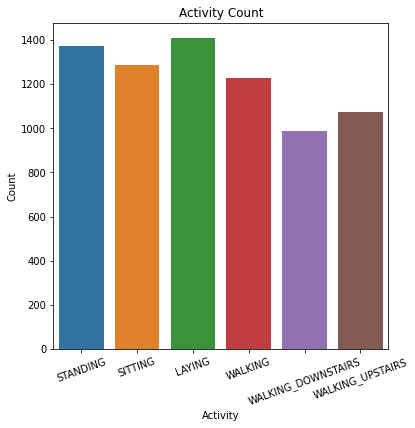

In [13]:
#Plot1 distribution of activities in train set
plt.figure(figsize=(6,6))
plt.title('Barplot of Activity')
plt.xticks(rotation=20)
sns.countplot(train.activity)
plt.xlabel("Activity")
plt.ylabel("Count")
plt.title("Activity Count")

In [14]:
#Plot2 distribution of activities subject-wise in train set
pd.crosstab(train.subject, train.activity, margins=True).style.background_gradient(cmap='PuBu')

activity,LAYING,SITTING,STANDING,WALKING,WALKING_DOWNSTAIRS,WALKING_UPSTAIRS,All
subject,,,,,,,
1,50,47,53,95,49,53,347
3,62,52,61,58,49,59,341
5,52,44,56,56,47,47,302
6,57,55,57,57,48,51,325
7,52,48,53,57,47,51,308
8,54,46,54,48,38,41,281
11,57,53,47,59,46,54,316
14,51,54,60,59,45,54,323
15,72,59,53,54,42,48,328


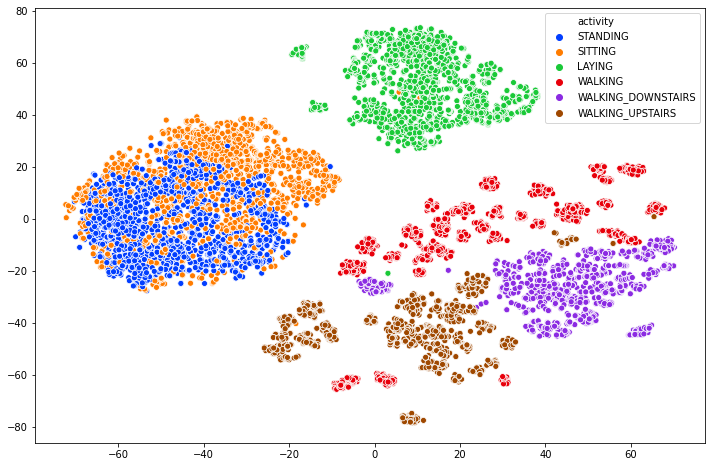

In [15]:
#Plot3 Visualising high-dimensions using TSNE
from sklearn.manifold import TSNE
X_for_tsne = train.drop([ 'subject', 'activity'], axis=1)
tsne = TSNE(random_state = 42, n_components=2, perplexity=50, n_iter=1000).fit_transform(X_for_tsne)
plt.figure(figsize=(12,8))
sns.scatterplot(x =tsne[:, 0], y = tsne[:, 1], hue = train["activity"],palette="bright")

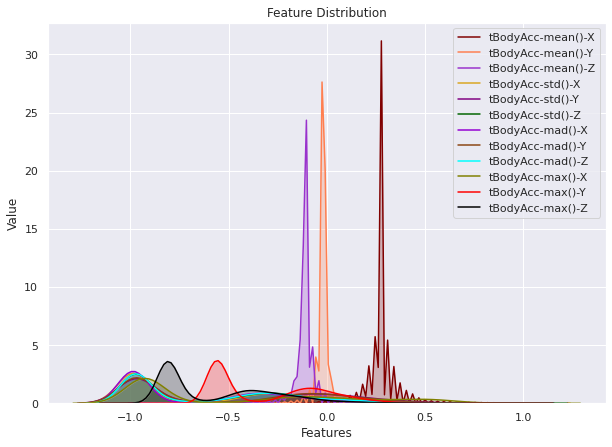

In [16]:
#Plot4 univariate kernel density estimate for features like mean, std, mad and max for accelerometer and gyroscope 3-axial raw signals tAcc-XYZ
sns.set(rc={'figure.figsize':(10,7)})
colours = ["maroon","coral","darkorchid","goldenrod","purple","darkgreen","darkviolet","saddlebrown","aqua","olive","red","black"]
index = -1
for i in train.columns[0:12]:
    index = index + 1
    fig = sns.kdeplot(train[i] , shade=True, color=colours[index])
plt.xlabel("Features")
plt.ylabel("Value")
plt.title("Feature Distribution")
plt.show(fig)

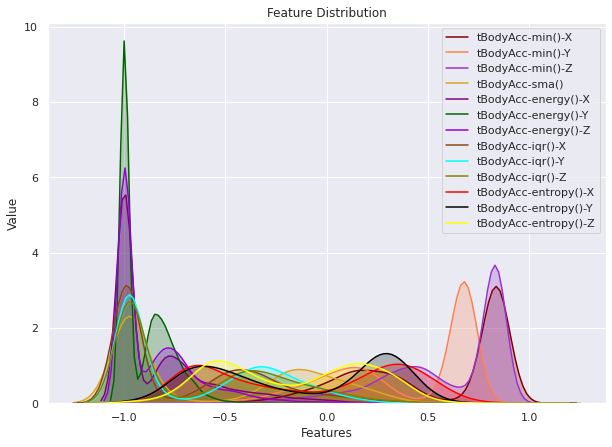

In [17]:
#Plot5 univariate kernel density estimate for features like min, sma, energy, iqr and entropy for accelerometer and gyroscope 3-axial raw signals tAcc-XYZ
sns.set(rc={'figure.figsize':(10,7)})
colours = ["maroon","coral","darkorchid","goldenrod","purple","darkgreen","darkviolet","saddlebrown","aqua","olive","red","black","yellow"]
index = -1
for i in train.columns[12:25]:
    index = index + 1
    fig = sns.kdeplot(train[i] , shade=True, color=colours[index])
plt.xlabel("Features")
plt.ylabel("Value")
plt.title("Feature Distribution")
plt.show(fig)

Feature Scaling and Data Pre-processing

In [18]:
#Checking nulls
train.isnull().values.any()
test.isnull().values.any()

False

Fortunately there are no missing values.



In [0]:
#Feature scaling - StandardScaler -- Standardize features by removing the mean and scaling to unit variance
sc = StandardScaler()
X_train= train.iloc[:,:-1].values
y_train= train.iloc[:,-1].values
X_test= test.iloc[:,:-1].values
y_test= test.iloc[:,-1].values

X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

Logistic Regression

In [20]:
# Fitting Logistic Regression to the Training set
classifier = LogisticRegression(random_state = 0, max_iter = 1500)
classifier.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1500,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=0, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

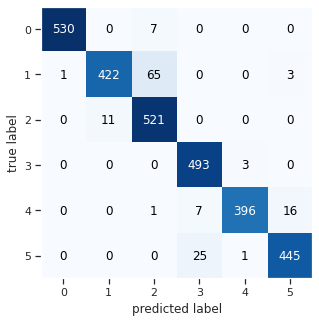

                    precision    recall  f1-score   support

            LAYING       1.00      0.99      0.99       537
           SITTING       0.97      0.86      0.91       491
          STANDING       0.88      0.98      0.93       532
           WALKING       0.94      0.99      0.97       496
WALKING_DOWNSTAIRS       0.99      0.94      0.97       420
  WALKING_UPSTAIRS       0.96      0.94      0.95       471

          accuracy                           0.95      2947
         macro avg       0.96      0.95      0.95      2947
      weighted avg       0.96      0.95      0.95      2947

Accuracy by Logistic Regression with All feature set is 95.24940617577197


In [21]:
# Predicting the Logistic Test set results
y_pred = classifier.predict(X_test)

# Making the Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
fig, ax = plot_confusion_matrix(conf_mat=cm ,  figsize=(10, 5))
plt.show()

#Classification Report and Accuracy
print(classification_report(y_test, y_pred))
accuracy_score=accuracy_score(y_test,y_pred)
print("Accuracy by Logistic Regression with All feature set is", accuracy_score*100)

Tree-based Feature Selection


In [22]:
clf = ExtraTreesClassifier()
clf = clf.fit(X_train, y_train)
model = SelectFromModel(clf, prefit=True)
New_features = model.transform(X_train)
print(New_features.shape)

feature_idx = model.get_support()
feature_name = train.iloc[:,0:562].columns[feature_idx]
feature_name

test_features= model.transform(X_test)

(7352, 158)


L1-based feature selection

In [23]:
from sklearn.svm import LinearSVC
lsvc = LinearSVC(C=0.01, penalty="l1", dual=False).fit(X_train, y_train)
model_2 = SelectFromModel(lsvc, prefit=True)
New_features_2 = model_2.transform(X_train)
print(New_features_2.shape)

feature_idx = model.get_support()
feature_name = train.iloc[:,0:562].columns[feature_idx]
feature_name

test_features_2 = model_2.transform(X_test)

(7352, 179)


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Modelling with whole data

In [24]:
model_name=['NaiveBayesClassifier','RandomForestClassifier','KNeighborsClassifier','GradientBoostingClassifier','AdaBoostClassifier','DecisionTreeClassifier']
models_list= [NB(),RF(),KNN(),GB(),AB(),DT()]
for i, j in zip(model_name, models_list):
    scores = cross_val_score(j, X_train, y_train, cv=5)
    print(i+"--"+ "Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

NaiveBayesClassifier--Accuracy: 0.69 (+/- 0.14)
RandomForestClassifier--Accuracy: 0.92 (+/- 0.04)
KNeighborsClassifier--Accuracy: 0.87 (+/- 0.02)
GradientBoostingClassifier--Accuracy: 0.92 (+/- 0.03)
AdaBoostClassifier--Accuracy: 0.54 (+/- 0.00)
DecisionTreeClassifier--Accuracy: 0.85 (+/- 0.07)


Modelling with features selected by Tree based method

In [25]:
model_name=['NaiveBayesClassifier','RandomForestClassifier','KNeighborsClassifier','GradientBoostingClassifier','AdaBoostClassifier','DecisionTreeClassifier']
models_list= [NB(),RF(),KNN(),GB(),AB(),DT()]
for i, j in zip(model_name, models_list):
    scores = cross_val_score(j, New_features, y_train, cv=5)
    print(i+"--"+ "Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

NaiveBayesClassifier--Accuracy: 0.85 (+/- 0.05)
RandomForestClassifier--Accuracy: 0.91 (+/- 0.03)
KNeighborsClassifier--Accuracy: 0.90 (+/- 0.04)
GradientBoostingClassifier--Accuracy: 0.92 (+/- 0.03)
AdaBoostClassifier--Accuracy: 0.54 (+/- 0.00)
DecisionTreeClassifier--Accuracy: 0.84 (+/- 0.09)


Modelling with features selected by L1 based method

In [26]:
model_name=['NaiveBayesClassifier','RandomForestClassifier','KNeighborsClassifier','GradientBoostingClassifier','AdaBoostClassifier','DecisionTreeClassifier']
models_list= [NB(),RF(),KNN(),GB(),AB(),DT()]
for i, j in zip(model_name, models_list):
    scores = cross_val_score(j, New_features_2, y_train, cv=5)
    print(i+"--"+ "Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

NaiveBayesClassifier--Accuracy: 0.85 (+/- 0.07)
RandomForestClassifier--Accuracy: 0.92 (+/- 0.04)
KNeighborsClassifier--Accuracy: 0.90 (+/- 0.05)
GradientBoostingClassifier--Accuracy: 0.93 (+/- 0.03)
AdaBoostClassifier--Accuracy: 0.54 (+/- 0.00)
DecisionTreeClassifier--Accuracy: 0.86 (+/- 0.06)


In [0]:
params_grid = [{'kernel': ['rbf'], 'gamma': [1e-3, 1e-4],
                     'C': [1, 10, 100, 1000]},
                    {'kernel': ['linear'], 'C': [1, 10, 100, 1000]}]

SVM Classifier on whole feature set

In [28]:
#Performing CV to tune parameters for best SVM fit 
svm_model = GridSearchCV(SVC(), params_grid, cv=5)
svm_model.fit(X_train, y_train)

# View the accuracy score
print('Best score for training data:', svm_model.best_score_,"\n") 

# View the best parameters for the model found using grid search
print('Best C:',svm_model.best_estimator_.C,"\n") 
print('Best Kernel:',svm_model.best_estimator_.kernel,"\n")
print('Best Gamma:',svm_model.best_estimator_.gamma,"\n")

Best score for training data: 0.9362155412810944 

Best C: 1000 

Best Kernel: rbf 

Best Gamma: 0.0001 



In [29]:
final_model = svm_model.best_estimator_
Y_pred = final_model.predict(X_test)

# Making the Confusion Matrix
print(confusion_matrix(y_test,Y_pred))
print("\n")
print(classification_report(y_test,Y_pred))

print("Training set score for SVM: %f" % final_model.score(X_train , y_train))
print("Testing  set score for SVM: %f" % final_model.score(X_test  , y_test ))

# svm_model.score

[[537   0   0   0   0   0]
 [  0 428  62   0   0   1]
 [  0  15 517   0   0   0]
 [  0   0   0 495   1   0]
 [  0   0   0   6 397  17]
 [  0   0   0  16   1 454]]


                    precision    recall  f1-score   support

            LAYING       1.00      1.00      1.00       537
           SITTING       0.97      0.87      0.92       491
          STANDING       0.89      0.97      0.93       532
           WALKING       0.96      1.00      0.98       496
WALKING_DOWNSTAIRS       0.99      0.95      0.97       420
  WALKING_UPSTAIRS       0.96      0.96      0.96       471

          accuracy                           0.96      2947
         macro avg       0.96      0.96      0.96      2947
      weighted avg       0.96      0.96      0.96      2947

Training set score for SVM: 0.997008
Testing  set score for SVM: 0.959620


SVM Classifier on feature set selected by Tree based method

In [30]:
#Performing CV to tune parameters for best SVM fit 
svm_model = GridSearchCV(SVC(), params_grid, cv=5)
svm_model.fit(New_features, y_train)

# View the accuracy score
print('Best score for training data:', svm_model.best_score_,"\n") 

# View the best parameters for the model found using grid search
print('Best C:',svm_model.best_estimator_.C,"\n") 
print('Best Kernel:',svm_model.best_estimator_.kernel,"\n")
print('Best Gamma:',svm_model.best_estimator_.gamma,"\n")

Best score for training data: 0.942472472333597 

Best C: 1000 

Best Kernel: rbf 

Best Gamma: 0.001 



In [31]:
final_model = svm_model.best_estimator_
Y_pred = final_model.predict(test_features)

# Making the Confusion Matrix
print(confusion_matrix(y_test,Y_pred))
print("\n")
print(classification_report(y_test,Y_pred))

print("Training set score for SVM: %f" % final_model.score(New_features , y_train))
print("Testing  set score for SVM: %f" % final_model.score(test_features  , y_test ))

# svm_model.score

[[537   0   0   0   0   0]
 [  0 437  52   0   0   2]
 [  0  19 513   0   0   0]
 [  0   0   0 491   1   4]
 [  0   0   0   6 399  15]
 [  0   0   0  30   6 435]]


                    precision    recall  f1-score   support

            LAYING       1.00      1.00      1.00       537
           SITTING       0.96      0.89      0.92       491
          STANDING       0.91      0.96      0.94       532
           WALKING       0.93      0.99      0.96       496
WALKING_DOWNSTAIRS       0.98      0.95      0.97       420
  WALKING_UPSTAIRS       0.95      0.92      0.94       471

          accuracy                           0.95      2947
         macro avg       0.96      0.95      0.95      2947
      weighted avg       0.96      0.95      0.95      2947

Training set score for SVM: 0.995103
Testing  set score for SVM: 0.954191


SVM Classifier on feature set seelcted by L1 based method

In [32]:
#Performing CV to tune parameters for best SVM fit 
svm_model = GridSearchCV(SVC(), params_grid, cv=5)
svm_model.fit(New_features_2, y_train)

# View the accuracy score
print('Best score for training data:', svm_model.best_score_,"\n") 

# View the best parameters for the model found using grid search
print('Best C:',svm_model.best_estimator_.C,"\n") 
print('Best Kernel:',svm_model.best_estimator_.kernel,"\n")
print('Best Gamma:',svm_model.best_estimator_.gamma,"\n")

Best score for training data: 0.947639765627529 

Best C: 1000 

Best Kernel: rbf 

Best Gamma: 0.0001 



In [33]:
final_model = svm_model.best_estimator_
Y_pred = final_model.predict(test_features_2)

# Making the Confusion Matrix
print(confusion_matrix(y_test,Y_pred))
print("\n")
print(classification_report(y_test,Y_pred))

print("Training set score for SVM: %f" % final_model.score(New_features_2 , y_train))
print("Testing  set score for SVM: %f" % final_model.score(test_features_2  , y_test ))

# svm_model.score

[[537   0   0   0   0   0]
 [  1 428  61   0   0   1]
 [  0  16 516   0   0   0]
 [  0   0   0 490   3   3]
 [  0   0   0   6 401  13]
 [  0   0   1  19   7 444]]


                    precision    recall  f1-score   support

            LAYING       1.00      1.00      1.00       537
           SITTING       0.96      0.87      0.92       491
          STANDING       0.89      0.97      0.93       532
           WALKING       0.95      0.99      0.97       496
WALKING_DOWNSTAIRS       0.98      0.95      0.97       420
  WALKING_UPSTAIRS       0.96      0.94      0.95       471

          accuracy                           0.96      2947
         macro avg       0.96      0.95      0.96      2947
      weighted avg       0.96      0.96      0.96      2947

Training set score for SVM: 0.993879
Testing  set score for SVM: 0.955548


Conclusion

Test Accuracy by Logistic Regression on whole feature set is 95.24%.
SVM classifier gives us 95.9% Test Accuracy when considered with all features,and 95.5% when considered with features selected by L1 based method and Tree based method.

The best model for the data seems like SVM with full feature set.

I also observed that the feature selection can impactfully decrease the running time of complicated model, without jeopardizing the performance of model.
The overall accuracy of the model will not be necessarily compromised by shrinking the size of the data set. The main reason is that good feature selection may prevent over-fitting to some extents.